В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
Review criteriaменьше 
Придерживайтесь стандартного алгоритма построения прогноза:

* Визуальный анализ ряда
* Стабилизация дисперсии (при необходимости)
* Выбор порядка дифференцирования
* Выбор начальных приближений для p,q,P,Q
* Обучение и сравнение моделей-кандидатов, выбор победителя
* Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными,  прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

* Прогнозирование с помощью финальной модели.

In [32]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
import warnings
from itertools import product
import numpy as np 

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
%matplotlib inline


In [2]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
# загрузили данные
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


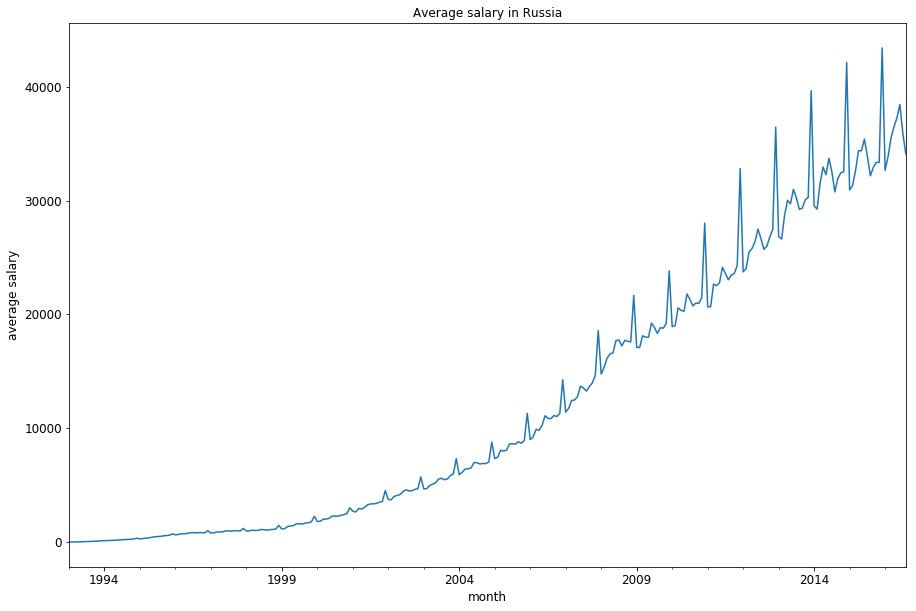

In [4]:
salary.rename(columns={'WAG_C_M': 'salary_rub'}, inplace=True)
salary.salary_rub.plot(figsize=(15, 10), title='Average salary in Russia', fontsize=12);
plt.xlabel('month', fontsize=12)
plt.ylabel('average salary', fontsize=12)
plt.show()

В рамках первичной визуалиции можно сразу отметить восходящий общий тренд. Сезонность с пиками в декабре и падением в январе(годовые премии). Рост дисперсии. Со всем этим нужно будет отдельно проанализировать

Критерий Дики-Фуллера: p=0.991850


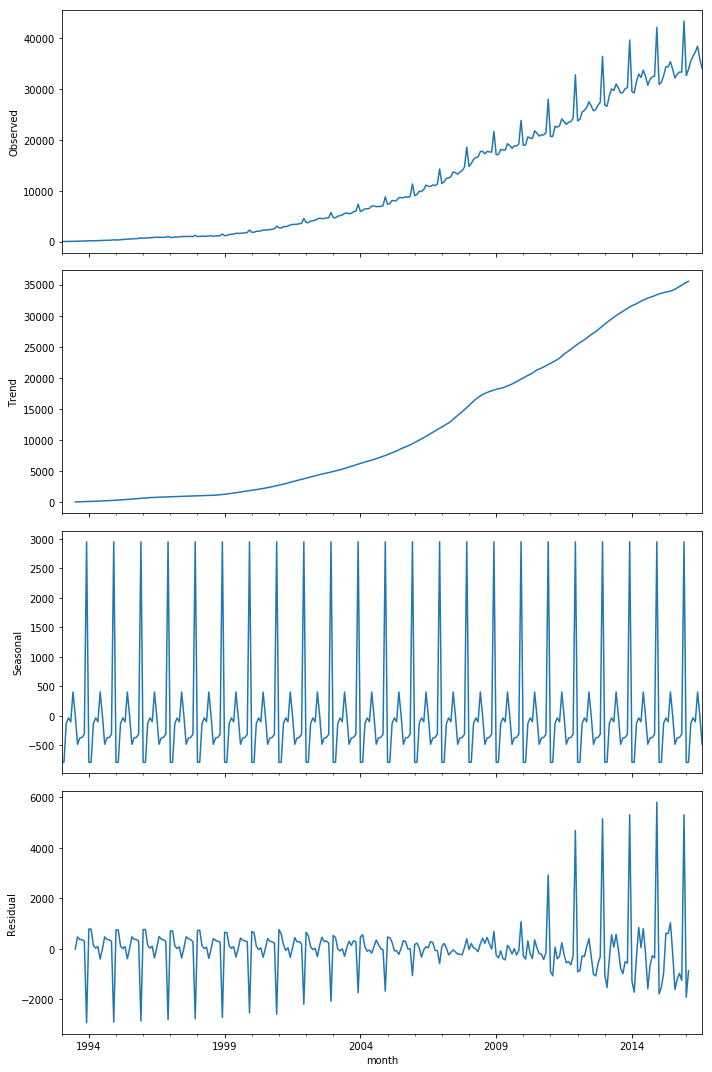

In [5]:
# Проверка стационарности и STL-декомпозиция ряда:
plt.rcParams["figure.figsize"] = (10,15)

sm.tsa.seasonal_decompose(salary.salary_rub).plot( )
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_rub)[1])

# Гипотеза о стационарности критерием Дики- Фуллера не потверждается. Но подождите тут ведь еще тренд и сезонность

## Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


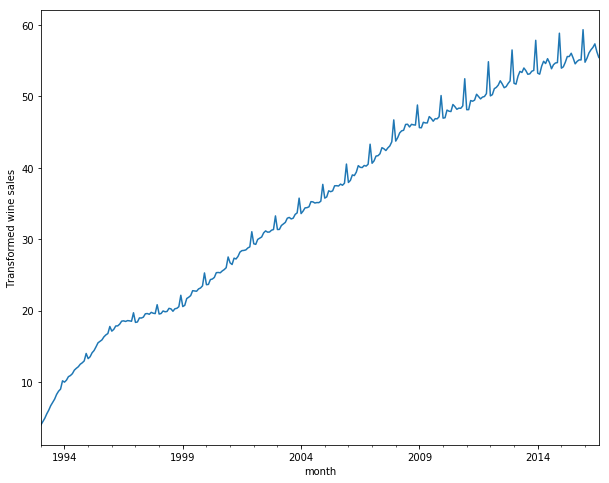

In [6]:
plt.rcParams["figure.figsize"] = (10,8)
salary['salary_box'], lmbda = stats.boxcox(salary.salary_rub)

salary.salary_box.plot()
plt.ylabel('Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

## Стационарность
 
Попробуем сезонное дифференцирование - чтобы избавиться от тренда

Критерий Дики-Фуллера: p=0.014697


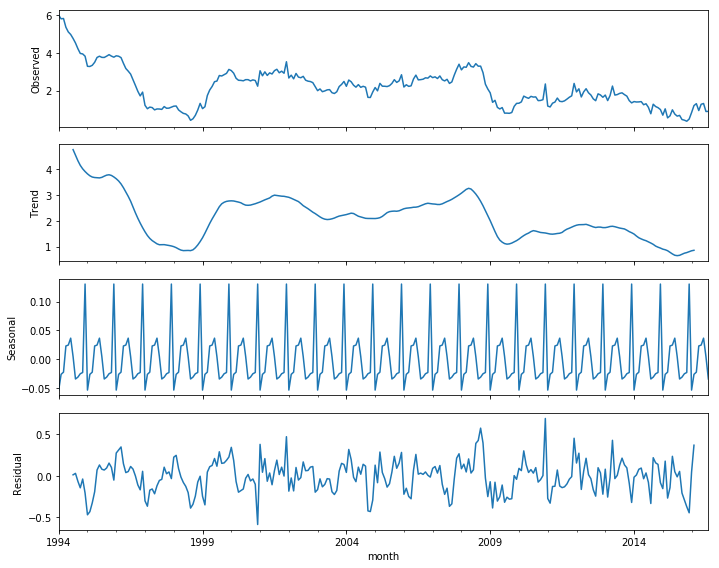

In [7]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)

sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


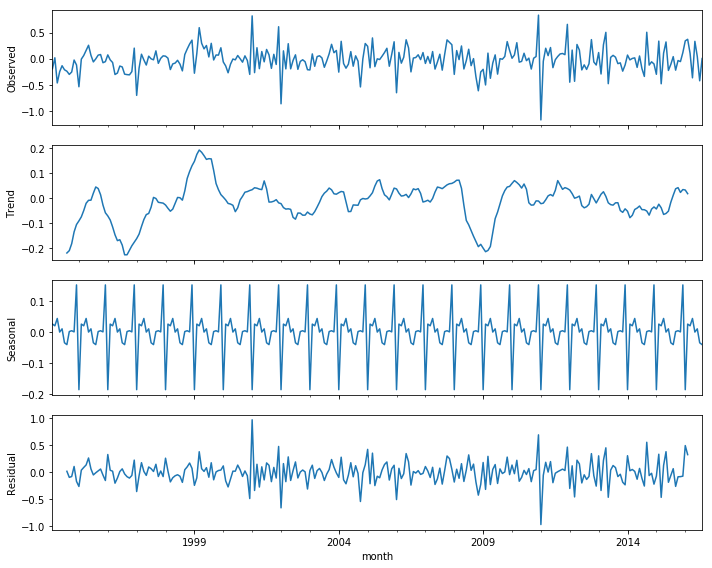

In [8]:
# Годовое диффернцирование не помогло, нужно еще раз

salary['salary_box_diff12_1'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
sm.tsa.seasonal_decompose(salary.salary_box_diff12_1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff12_1[13:])[1])


Это победа. Получили стационарный ряд. Lets rock

In [9]:
salary.salary_box_diff = salary.salary_box_diff12_1
salary.drop('salary_box_diff12_1', axis=1, inplace=True)

## SARIMA - наше всё

Посмотрим на ACF и PACF полученного ряда


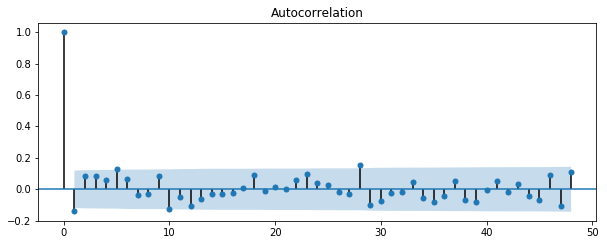

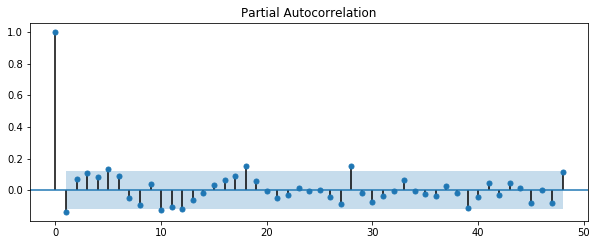

In [12]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q = 0, q = 1, P = 1, p = 18

сезонных лагов со значимой корреляцией нет, значит, начальное приближение Q = 0

In [16]:
ps = range(0, 19)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

76

In [24]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
CPU times: user 11min 11s, sys: 6.52 s, total: 11min 17s
Wall time: 2min 59s


In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
46  (12, 0, 1, 0) -10.262124
42  (11, 0, 1, 0)  -9.662085
44  (11, 1, 1, 0)  -9.509328
69  (18, 0, 0, 0)  -8.464590
50  (13, 0, 1, 0)  -8.290496


In [26]:
# Лучшая модель:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(12, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  19.131
Date:                             Sat, 11 Nov 2017   AIC                            -10.262
Time:                                     22:53:14   BIC                             40.824
Sample:                                 01-01-1993   HQIC                            10.219
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2281      0.047     -4.840      0.000      -0.320      -0.136
ar.L2          0.0086      

Критерий Стьюдента: p=0.182360
Критерий Дики-Фуллера: p=0.000000


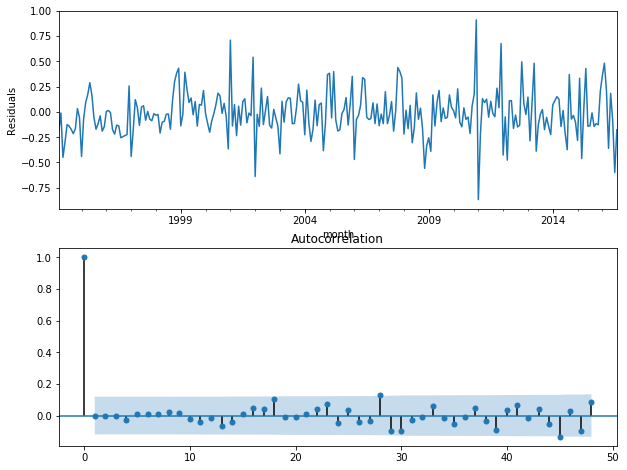

In [27]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.182360
Критерий Дики-Фуллера: p=0.000000


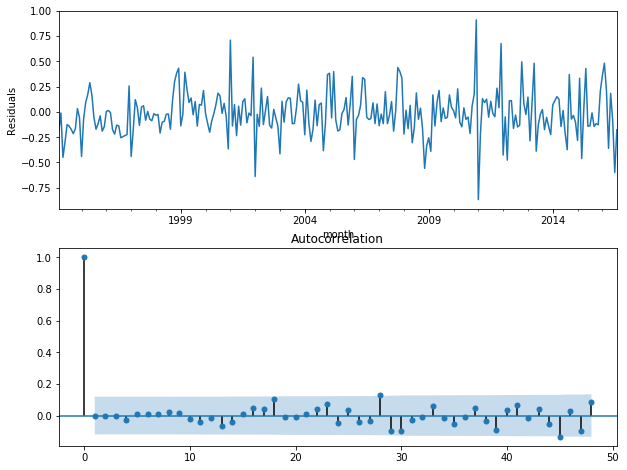

In [29]:
# Посмотрим на остатки модели:

plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

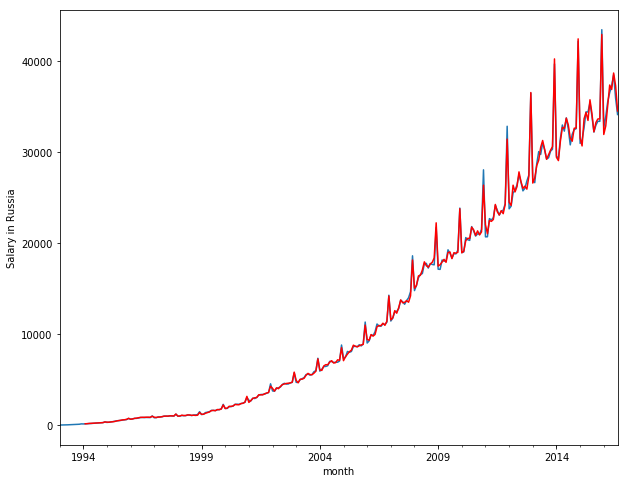

In [35]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.rcParams["figure.figsize"] = (10,8)

salary.salary_rub.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary in Russia')
plt.show()

Модель описывает реальные данные очень даже хорошо

## Прогноз

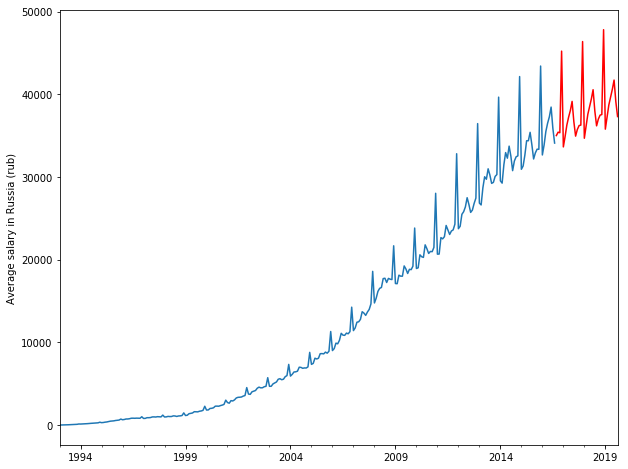

In [55]:
from datetime import datetime
import datetime
from dateutil.relativedelta import *
salary2 = salary[['salary_rub']]

date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salary2.columns)

salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=325), lmbda)

salary2.salary_rub.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Average salary in Russia (rub)')
plt.show()